In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich]

In [2]:
from time import time
from discopy.pregroup import brute_force

gen, n_sentences = brute_force(*vocab), 10
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.

7.34 seconds to generate 10 sentences.


Diagram for 'Alice who loves Bob is rich.':


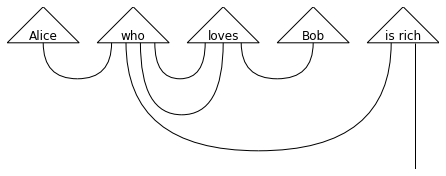

In [3]:
from discopy.pregroup import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice who loves Bob is rich.'], draw_types=False)

Circuit for the GHZ state:


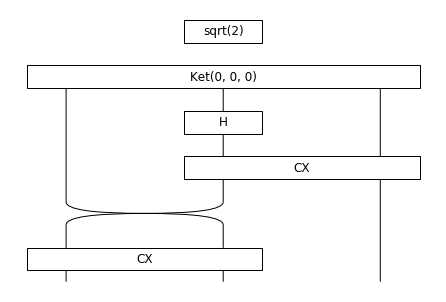

Matrix(dom=Dim(1), cod=Dim(2, 2, 2), array=[0.99999994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99999994])


In [4]:
from discopy.circuit import Circuit, sqrt, Ket, H, Rx, CX, SWAP

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state:")
GHZ.draw(aspect='auto', draw_types=False)
print(GHZ.eval())

Circuit for 'Alice who loves Bob is rich.':


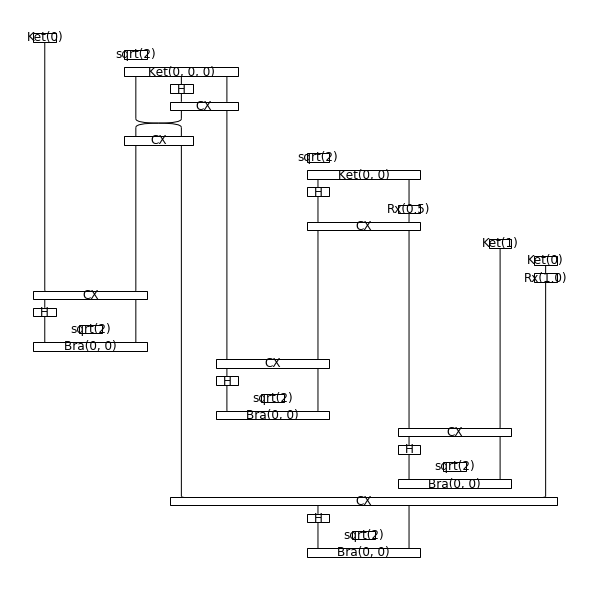

In [5]:
import numpy as np
from discopy import CircuitFunctor

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    Bob: Ket(1),
    who: GHZ,
    is_rich: intransitive_ansatz(params['is_rich'])}

F = lambda params: CircuitFunctor(ob, ar({'loves': params[0], 'is_rich': params[1]}))

params0 = np.array([0.5, 1.])
print("Circuit for 'Alice who loves Bob is rich.':")
F(params0)(parsing['Alice who loves Bob is rich.']).draw(
    figsize=(8, 8), aspect='auto', draw_types=False)

In [6]:
from pytket.backends.ibm import AerBackend, IBMQBackend
from qiskit.providers.aer import noise

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.aer import noise

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)

backend = AerBackend(noise_model)

evaluate = lambda F, sentence: F(parsing[sentence]).get_counts(backend, n_shots=2**10).array

In [7]:
from time import time

start = time()
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}
print("{} seconds to compute the corpus.".format(time() - start))

epsilon = .33

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

33.20731067657471 seconds to compute the corpus.
True sentences:
Alice is rich.
Alice loves Bob.
Bob loves Alice.
Alice who is rich is rich.

False sentences:
Bob is rich.
Alice loves Alice.
Bob loves Bob.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.


In [8]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(str, sentence_test))))

Training set:
Alice loves Alice.
Alice who loves Bob is rich.
Bob loves Alice.
Alice loves Bob.
Alice who is rich is rich.

Testing set:
Alice who loves Alice is rich.
Bob is rich.
Bob loves Bob.
Alice is rich.
Bob who is rich is rich.


In [9]:
import numpy as np

def training_loss(params):
    return - np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_train]))

def testing_loss(params):
    return - np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_test]))

start = time()
print("Training loss: {}".format(training_loss(params0)))
print("Testing loss: {}".format(testing_loss(params0)))
print("\n{:.0f} seconds to compile the loss.".format(time() - start))

Training loss: -0.03698728606104851
Testing loss: -0.004239654168486595

25 seconds to compile the loss.


In [22]:
from random import random

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))
print("Initial training loss: {}".format(training_loss(params)))
print("Initial testing loss: {}".format(testing_loss(params)))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(params), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Random initialisation: [0.27260638 0.0955924 ]
Initial training loss: -0.17442619800567627
Initial testing loss: -0.03573149815201759

Is Alice who loves Bob rich?
No, she isn't.


In [29]:
import noisyopt

result = noisyopt.minimizeSPSA(
    training_loss, params, paired=False, callback=print, niter=5, a=2)
result

[0.2785688  0.10155481]
[0.32719676 0.15018278]
[0.3490974  0.17208342]
[0.46492998 0.05625084]
[0.4441689  0.03548976]


     fun: -0.034863263
 message: 'terminated after reaching max number of iterations'
    nfev: 10
     nit: 5
 success: True
       x: array([0.4441689 , 0.03548976])

In [33]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(result.x), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Is Alice who loves Bob rich?
Yes, she is.
